# Comment Topic and Sentiment : Aspect-Based LDA Topic Modeling

This notebook performs aspect-based topic modeling and sentiment analysis on YouTube comments using Latent Dirichlet Allocation (LDA). The workflow includes:

- Data loading, cleaning, and merging for comments and video metadata
- Exploding aspect and sentiment columns for detailed analysis
- Separating comments by sentiment (negative/positive) and aspect (makeup, hair, skin, perfume, body)
- Vectorizing text data and training LDA models to discover topics within each sentiment and aspect category
- Assigning dominant topics and confidence scores to each comment
- Visualizing and summarizing topic distributions for both negative and positive comments
- Saving comprehensive topic count results to CSV for further analysis

This approach enables a detailed understanding of the main themes and sentiments expressed in comments for each product aspect, supporting actionable insights for content and product strategy.

## Import Required Libraries
Import the necessary libraries for data manipulation, text vectorization, and topic modeling. This includes pandas, scikit-learn's CountVectorizer and LatentDirichletAllocation, numpy, and ast for data parsing.

In [58]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import ast

## Load Dataset
Read the preprocessed dataset containing comments and KPIs from a CSV file into a pandas DataFrame. Display the first few rows to verify successful loading and inspect the data structure.

In [ ]:
# Load the dataset containing comments and KPIs
# Display the first few rows to inspect the data structure
data = pd.read_csv('dataset/final_dataset_with_kpi.csv')
data.head()

,commentId,channelId,videoId,authorId,textOriginal,parentCommentId,likeCount,publishedAt,updatedAt,duplicatedFlag,...,predicted_spam,isSpam,is_english,relevance_score,negative,neutral,positive,aspect,sentiment,KPI
0,732985,50368,21218,440354,This Navratri makeup tutorial is perfect for b...,NaN,1,2024-10-07 14:33:12+00:00,2024-10-07 14:33:12+00:00,0,...,0.0,0,1,0.869423,0.016649,0.052854,0.930497,"['makeup tutorial', 'lip']","['Positive', 'Positive']",0.685384
1,2260379,14429,69445,1025481,"That is not what men think no makeup is, that ...",NaN,0,2023-08-05 11:43:47+00:00,2023-08-05 11:43:47+00:00,0,...,0.0,0,1,0.754436,0.945486,0.038934,0.015580,['color'],['Negative'],0.680329
2,3689418,14429,69445,2321622,"No one's gonna like this, but I think the main...",NaN,2,2025-01-02 01:37:59+00:00,2025-01-02 01:37:59+00:00,0,...,0.0,0,1,0.780013,0.853927,0.116936,0.029137,"['beauty', 'skin', 'eye', 'lip']","['Negative', 'Negative', 'Negative', 'Negative']",0.663095
3,3521557,18073,34950,2076266,Indian traditional makeup is just wow it's sim...,NaN,0,2021-07-12 10:44:50+00:00,2021-07-12 10:44:50+00:00,0,...,0.0,0,1,0.857476,0.008585,0.021154,0.970262,['makeup'],['Positive'],0.659377
4,4341727,32562,11402,1792614,"Oh woow Allure, what a great every day 10 minu...",NaN,55,2022-09-28 23:04:20+00:00,2022-10-01 11:33:21+00:00,0,...,0.0,0,1,0.748480,0.010089,0.011792,0.978118,['taste'],['Positive'],0.658192


## Check DataFrame Shape
Display the shape of the DataFrame to understand the number of rows and columns in the loaded dataset.

In [ ]:
# Display the shape of the DataFrame to check the number of rows and columns
data.shape

(2014093, 23)

## Check for Missing Values
Display the number of missing values in each column to assess data quality and identify columns that may require cleaning or imputation.

In [4]:
filtered_data = data[data['aspect']!="[]"]
filtered_data.shape

(1137958, 23)

## Load Video Engagement Data
Read the video-level engagement scores from a CSV file into a pandas DataFrame. Display the first few rows to inspect the structure and verify successful loading.

In [5]:
video=pd.read_csv('video_with_engagement_score.csv')
video.head()

,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,...,is_english,translated,extracted_topicCategories,extracted_topicCategories_str,dominant_topic,topic_confidence,topic_label,average_kpi,comment_count,video_engagement_score
0,78245,2023-10-20 16:00:42+00:00,41338,Sydney Sweeney Perfecting the Shot,We're taking you behind the scenes on Sydney S...,NaN,NaN,en-US,PT18S,264368764.0,...,1,sydney sweeney perfecting shot,"['Entertainment', 'Physical_attractiveness']","Entertainment, Physical_attractiveness",4.0,0.440306,body,0.255842,1773,1.000000
1,59850,2024-11-08 21:00:36+00:00,45729,it’s FREAKY FRIDAY!! Her brows are made of GEMS…,NaN,NaN,en-US,en-US,PT47S,252195721.0,...,1,freaky friday brow made gem,"['Lifestyle_(sociology)', 'Physical_attractive...","Lifestyle_(sociology), Physical_attractiveness",4.0,0.440917,body,0.284013,2015,0.981042
2,32656,2023-06-22 21:10:28+00:00,6926,Which is your favortie? #hairstyle #shortvideo...,Brooke Monk Socials:\nFanfix: https://app.fanf...,NaN,NaN,NaN,PT58S,83582866.0,...,1,favortie hairstyle shortvideo short short,"['Lifestyle_(sociology)', 'Physical_attractive...","Lifestyle_(sociology), Physical_attractiveness",3.0,0.865761,hair,0.282932,33137,0.971054
3,14688,2024-01-08 13:23:58+00:00,26428,Korean Secret Glowing Skin Mask | Beauty Secre...,Korean Secret Glowing Skin Mask | Beauty Secre...,NaN,NaN,NaN,PT27S,405748145.0,...,1,korean secret glowing skin mask | beauty secre...,"['Lifestyle_(sociology)', 'Physical_attractive...","Lifestyle_(sociology), Physical_attractiveness",1.0,0.926275,makeup,0.249368,636,0.960695
4,61512,2021-05-15 11:34:21+00:00,48780,Pakistan cute girls makeup video| very good ma...,Pakistan cute girls makeup video| very good ma...,NaN,NaN,NaN,PT30S,64574323.0,...,1,pakistan cute girl makeup video| good makeup v...,"['Lifestyle_(sociology)', 'Physical_attractive...","Lifestyle_(sociology), Physical_attractiveness",3.0,0.557294,hair,0.289186,1781,0.960018


## Merge Comment and Video Topic Data
Combine the filtered comment data with video-level topic labels by merging on the 'videoId' column. This enables analysis of comment aspects in the context of each video's dominant topic.

In [6]:
merged_data = filtered_data.merge(video[['videoId','topic_label']], on='videoId', how='left')

## Preview Merged Data
Display the first few rows of the merged DataFrame to verify the merge operation and inspect the combined comment and video topic information.

In [ ]:
merged_data.head()

,commentId,channelId,videoId,authorId,textOriginal,parentCommentId,likeCount,publishedAt,updatedAt,duplicatedFlag,...,isSpam,is_english,relevance_score,negative,neutral,positive,aspect,sentiment,KPI,topic_label
0,732985,50368,21218,440354,This Navratri makeup tutorial is perfect for b...,NaN,1,2024-10-07 14:33:12+00:00,2024-10-07 14:33:12+00:00,0,...,0,1,0.869423,0.016649,0.052854,0.930497,"['makeup tutorial', 'lip']","['Positive', 'Positive']",0.685384,makeup
1,2260379,14429,69445,1025481,"That is not what men think no makeup is, that ...",NaN,0,2023-08-05 11:43:47+00:00,2023-08-05 11:43:47+00:00,0,...,0,1,0.754436,0.945486,0.038934,0.015580,['color'],['Negative'],0.680329,makeup
2,3689418,14429,69445,2321622,"No one's gonna like this, but I think the main...",NaN,2,2025-01-02 01:37:59+00:00,2025-01-02 01:37:59+00:00,0,...,0,1,0.780013,0.853927,0.116936,0.029137,"['beauty', 'skin', 'eye', 'lip']","['Negative', 'Negative', 'Negative', 'Negative']",0.663095,makeup
3,3521557,18073,34950,2076266,Indian traditional makeup is just wow it's sim...,NaN,0,2021-07-12 10:44:50+00:00,2021-07-12 10:44:50+00:00,0,...,0,1,0.857476,0.008585,0.021154,0.970262,['makeup'],['Positive'],0.659377,makeup
4,4341727,32562,11402,1792614,"Oh woow Allure, what a great every day 10 minu...",NaN,55,2022-09-28 23:04:20+00:00,2022-10-01 11:33:21+00:00,0,...,0,1,0.748480,0.010089,0.011792,0.978118,['taste'],['Positive'],0.658192,makeup


## Analyze Topic Label Distribution
Count the occurrences of each topic label in the merged DataFrame to understand the distribution of topics across all comments and videos.

In [9]:
merged_data['topic_label'].value_counts()

topic_label
makeup     513922
hair       314909
skin       126166
perfume     75835
body        61929
Name: count, dtype: int64

## Prepare Data for Aspect-Based Analysis (Overall Comments)
Convert the 'aspect' and 'sentiment' columns from string representations to Python lists using `ast.literal_eval`, then explode these columns so each row represents a single aspect-sentiment pair for overall comments. This transformation enables detailed aspect-level sentiment analysis.

In [132]:
merged_data['aspect'] = merged_data['aspect'].apply(ast.literal_eval)
merged_data['sentiment'] = merged_data['sentiment'].apply(ast.literal_eval)
exploded = merged_data.explode(['aspect', 'sentiment'])

### Separate the exploded data into negative and positive sentiment subsets
This step filters the exploded DataFrame to create two new DataFrames: one containing only the rows with 'Negative' sentiment and another with 'Positive' sentiment. This allows for separate analysis of comments based on their sentiment polarity.

In [133]:
negative_data = exploded[exploded['sentiment'] == 'Negative']
positive_data = exploded[exploded['sentiment'] == 'Positive']

### Convert negative aspect comments to a list and vectorize
This step prepares the negative sentiment aspect comments for topic modeling. It converts the 'aspect' column of the negative sentiment data into a list of strings, then uses a CountVectorizer to transform the text data into a document-term matrix suitable for LDA or other topic modeling techniques.

In [ ]:
# === 1. Convert Comments to List ===
corpus = negative_data['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus)


### Retrain LDA model with best parameters and evaluate
This section retrains the Latent Dirichlet Allocation (LDA) model using the best hyperparameters found previously. The model is fit on the full vectorized dataset of negative aspect comments. After training, the model's performance is evaluated using log likelihood and perplexity metrics, and the shape of the resulting document-topic matrix is displayed.

In [135]:
# === 5. Final Retrain with Best Params ===
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_neg = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

# lda_topics_v2 contains document-topic distributions ===
print("Shape of document-topic matrix:", lda_topics_neg.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -2201296.072027368
Perplexity: 653.5926192525907
Shape of document-topic matrix: (323266, 5)


### Define a function to print LDA topics and top words
This cell defines a utility function to display the top words for each topic discovered by the LDA model. It normalizes the topic-word matrix to probabilities, retrieves the top words for each topic, and prints them along with their probabilities or raw weights. The function also returns a dictionary of keywords per topic for further analysis.

In [ ]:
def print_topics(model, vectorizer, top_n=10, show_probs=True):
    keywords_per_topic = {}
    feature_names = vectorizer.get_feature_names_out()
    
    # Normalize components_ to probabilities (P(word | topic))
    topic_word_prob = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    for idx, topic in enumerate(topic_word_prob):
        top_features = topic.argsort()[:-top_n - 1:-1]
        
        if show_probs:
            top_words = [(feature_names[i], round(topic[i], 4)) for i in top_features]
        else:
            # fallback to raw weights
            top_words = [(feature_names[i], round(model.components_[idx, i], 2)) for i in top_features]
        
        keywords_per_topic[f"Topic {idx+1}"] = top_words
        print(f"\nTopic {idx+1}: {top_words}")
    
    return keywords_per_topic

### Print the top words for each LDA topic
This cell prints the top words for each topic discovered by the trained LDA model, along with their probabilities. The results help interpret the main themes present in the negative aspect comments.

In [ ]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('lip', np.float64(0.062)), ('wig', np.float64(0.0497)), ('video', np.float64(0.0495)), ('filter', np.float64(0.0393)), ('eyeliner', np.float64(0.0244)), ('hairstyle', np.float64(0.0213)), ('price', np.float64(0.0193)), ('voice', np.float64(0.0189)), ('neck', np.float64(0.016)), ('comment', np.float64(0.0154))]

Topic 2: [('color', np.float64(0.0808)), ('look', np.float64(0.0422)), ('eye', np.float64(0.0405)), ('colour', np.float64(0.0351)), ('nose', np.float64(0.0301)), ('dress', np.float64(0.0216)), ('sound', np.float64(0.0185)), ('tip', np.float64(0.0181)), ('boy', np.float64(0.0149)), ('trend', np.float64(0.0146))]

Topic 3: [('skin', np.float64(0.0766)), ('face', np.float64(0.0418)), ('style', np.float64(0.0356)), ('girl', np.float64(0.0319)), ('lipstick', np.float64(0.0301)), ('nail', np.float64(0.0226)), ('woman', np.float64(0.0217)), ('water', np.float64(0.0176)), ('haircut', np.float64(0.016)), ('curl', np.float64(0.0152))]

Topic 4:

### Assign human-readable labels to LDA topics
This cell assigns a representative keyword to each LDA topic by selecting the most probable word for each topic. These labels help interpret and summarize the discovered topics, making it easier to understand the main themes in the data.

In [138]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'lip', 1: 'color', 2: 'skin', 3: 'makeup', 4: 'foundation'}


### Assign dominant topic and confidence to each comment
This cell assigns the most likely topic (dominant topic), the confidence score, and the topic label to each negative aspect comment. It updates the DataFrame with these values for further analysis and interpretation of topic assignments at the comment level.

In [139]:
# Initialize columns with NaN
negative_data['dominant_topic_comment'] = np.nan
negative_data['topic_confidence_comment'] = np.nan
negative_data['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = negative_data['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_neg, axis=1)
topic_confidence = lda_topics_neg.max(axis=1)

# Assign back to the non-null rows
negative_data.loc[mask, 'dominant_topic_comment'] = dominant_topic
negative_data.loc[mask, 'topic_confidence_comment'] = topic_confidence
negative_data.loc[mask, 'topic_label_comment'] = negative_data.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\902309733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\902309733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\902309733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

### Count the number of comments per topic label
This cell calculates and displays the frequency of each topic label assigned to the negative aspect comments. It helps to understand the distribution of topics within the negative sentiment data.

In [140]:
topic_counts_neg = negative_data['topic_label_comment'].value_counts()
topic_counts_neg

topic_label_comment
makeup        91309
lip           60058
color         57965
foundation    57817
skin          56117
Name: count, dtype: int64

### Visualize the distribution of topic counts
This cell creates a bar plot to visualize the number of negative aspect comments assigned to each topic label. The plot helps to quickly identify which topics are most prevalent in the negative sentiment data.

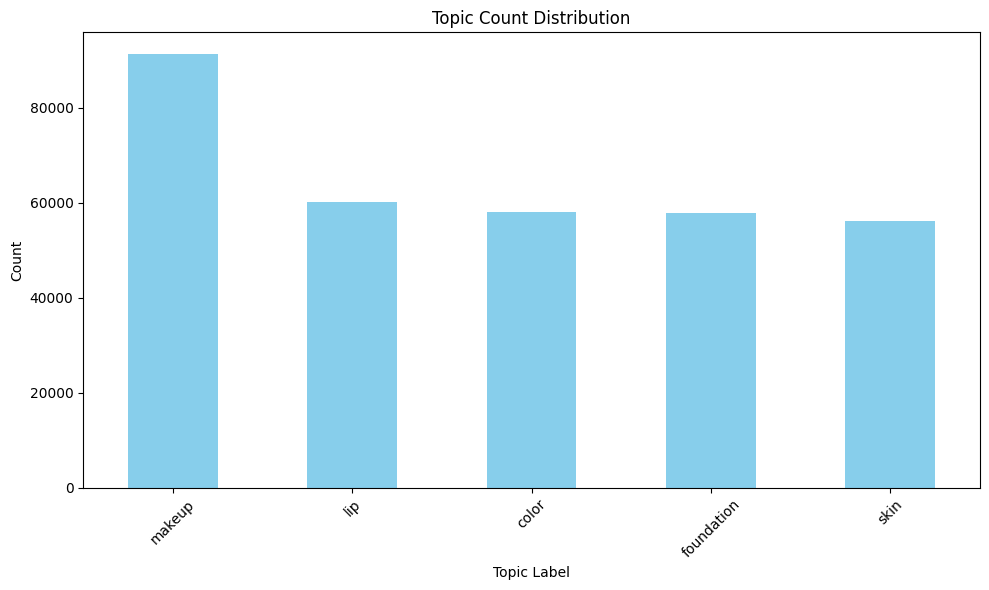

In [141]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_neg.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Repeat the same process for positive comments
The same topic modeling and analysis steps are applied to the positive aspect comments. This ensures that both negative and positive comment categories are analyzed consistently, allowing for a comprehensive comparison of topics across sentiment categories.

In [142]:
# === 1. Convert Comments to List ===
corpus = positive_data['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus)


In [143]:
# === 5. Final Retrain with Best Params ===
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_pos = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

# lda_topics_v2 contains document-topic distributions ===
print("Shape of document-topic matrix:", lda_topics_pos.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -2538630.4280547206
Perplexity: 541.3763129468442
Shape of document-topic matrix: (388663, 5)


In [144]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('video', np.float64(0.1453)), ('beauty', np.float64(0.1043)), ('india', np.float64(0.0579)), ('wig', np.float64(0.0439)), ('face', np.float64(0.0386)), ('hairstyle', np.float64(0.0354)), ('foundation', np.float64(0.0202)), ('body', np.float64(0.0137)), ('feature', np.float64(0.0123)), ('trend', np.float64(0.0122))]

Topic 2: [('lip', np.float64(0.0331)), ('ginger', np.float64(0.0266)), ('fit', np.float64(0.023)), ('accent', np.float64(0.0176)), ('make', np.float64(0.0167)), ('day', np.float64(0.0162)), ('boy', np.float64(0.0144)), ('suit', np.float64(0.0119)), ('selena', np.float64(0.0098)), ('woman', np.float64(0.0097))]

Topic 3: [('looking', np.float64(0.0847)), ('color', np.float64(0.0824)), ('voice', np.float64(0.0315)), ('smile', np.float64(0.0267)), ('guy', np.float64(0.0258)), ('god', np.float64(0.024)), ('content', np.float64(0.0225)), ('vibe', np.float64(0.0202)), ('love', np.float64(0.0191)), ('tutorial', np.float64(0.0179))]

Top

In [145]:
# Initialize columns with NaN
positive_data['dominant_topic_comment'] = np.nan
positive_data['topic_confidence_comment'] = np.nan
positive_data['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = positive_data['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_pos, axis=1)
topic_confidence = lda_topics_pos.max(axis=1)

# Assign back to the non-null rows
positive_data.loc[mask, 'dominant_topic_comment'] = dominant_topic
positive_data.loc[mask, 'topic_confidence_comment'] = topic_confidence
positive_data.loc[mask, 'topic_label_comment'] = positive_data.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\613642139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\613642139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\613642139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [146]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'video', 1: 'lip', 2: 'looking', 3: 'look', 4: 'night'}


In [147]:
topic_counts_pos = positive_data['topic_label_comment'].value_counts()
topic_counts_pos

topic_label_comment
makeup        136391
skin           66937
foundation     65232
lip            61057
color          59046
Name: count, dtype: int64

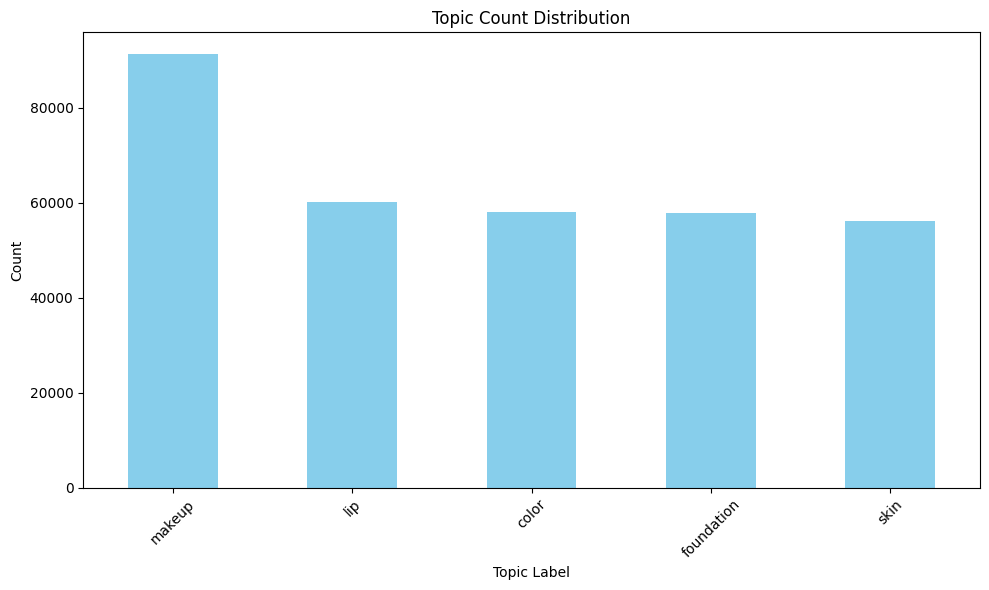

In [148]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_neg.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Filter merged data by topic label
This cell creates separate DataFrames for each main topic (makeup, hair, skin, perfume, body) by filtering the merged data according to the assigned topic label. This allows for targeted analysis of comments related to each specific aspect.

In [62]:
makeup=merged_data[merged_data['topic_label']=='makeup']
hair=merged_data[merged_data['topic_label']=='hair']
skin=merged_data[merged_data['topic_label']=='skin']
perfume=merged_data[merged_data['topic_label']=='perfume']
body=merged_data[merged_data['topic_label']=='body']


### Explode aspect and sentiment columns for each topic
This cell processes each main topic DataFrame (makeup, hair, skin, perfume, body) by converting the 'aspect' and 'sentiment' columns from string representations of lists to actual lists, then explodes them so each row represents a single (aspect, sentiment) pair. This prepares the data for further aspect-based sentiment analysis within each topic.

In [63]:
#Makeup
makeup['aspect'] = makeup['aspect'].apply(ast.literal_eval)
makeup['sentiment'] = makeup['sentiment'].apply(ast.literal_eval)
# Create a DataFrame where each row is a (aspect, sentiment) pair
exploded_makeup = makeup.explode(['aspect', 'sentiment'])

#Hair
hair['aspect'] = hair['aspect'].apply(ast.literal_eval)
hair['sentiment'] = hair['sentiment'].apply(ast.literal_eval)
exploded_hair = hair.explode(['aspect', 'sentiment'])

#Skin
skin['aspect'] = skin['aspect'].apply(ast.literal_eval)
skin['sentiment'] = skin['sentiment'].apply(ast.literal_eval)
exploded_skin = skin.explode(['aspect', 'sentiment'])

#Perfume
perfume['aspect'] = perfume['aspect'].apply(ast.literal_eval)
perfume['sentiment'] = perfume['sentiment'].apply(ast.literal_eval)
exploded_perfume = perfume.explode(['aspect', 'sentiment'])


#Body
body['aspect'] = body['aspect'].apply(ast.literal_eval)
body['sentiment'] = body['sentiment'].apply(ast.literal_eval)
exploded_body = body.explode(['aspect', 'sentiment'])

C:\Users\user\AppData\Local\Temp\ipykernel_1964\3608268105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  makeup['aspect'] = makeup['aspect'].apply(ast.literal_eval)
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3608268105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  makeup['sentiment'] = makeup['sentiment'].apply(ast.literal_eval)
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3608268105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

### Split exploded topic data by sentiment
This cell separates the exploded DataFrames for each topic (makeup, hair, skin, perfume, body) into negative and positive sentiment subsets. This enables independent analysis of positive and negative comments for each product aspect.

In [64]:
negative_data_makeup = exploded_makeup[exploded_makeup['sentiment'] == 'Negative']
positive_data_makeup = exploded_makeup[exploded_makeup['sentiment'] == 'Positive']

negative_data_hair = exploded_hair[exploded_hair['sentiment'] == 'Negative']
positive_data_hair = exploded_hair[exploded_hair['sentiment'] == 'Positive']

negative_data_skin = exploded_skin[exploded_skin['sentiment'] == 'Negative']
positive_data_skin = exploded_skin[exploded_skin['sentiment'] == 'Positive']

negative_data_perfume = exploded_perfume[exploded_perfume['sentiment'] == 'Negative']
positive_data_perfume = exploded_perfume[exploded_perfume['sentiment'] == 'Positive']

negative_data_body = exploded_body[exploded_body['sentiment'] == 'Negative']
positive_data_body = exploded_body[exploded_body['sentiment'] == 'Positive']


### Repeat the same process for makeup category
The same topic modeling and analysis steps are applied to the makeup aspect comments. Both negative and positive comments related to makeup are analyzed using the same workflow, enabling a detailed comparison of topics and sentiments within this product category.

In [ ]:
# === 1. Convert Comments to List ===
corpus_neg_makeup = negative_data_makeup['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_neg_makeup)

In [37]:
# === 5. Final Retrain with Best Params ===
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_neg_makeup = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

# lda_topics_v2 contains document-topic distributions ===
print("Shape of document-topic matrix:", lda_topics_neg_makeup.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -983051.8672210341
Perplexity: 582.5717525351107
Shape of document-topic matrix: (146817, 5)


In [40]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('face', np.float64(0.0443)), ('eyebrow', np.float64(0.031)), ('shade', np.float64(0.0277)), ('colour', np.float64(0.0276)), ('product', np.float64(0.0274)), ('filter', np.float64(0.0224)), ('tip', np.float64(0.0197)), ('style', np.float64(0.0196)), ('neck', np.float64(0.0153)), ('comment', np.float64(0.0145))]

Topic 2: [('skin', np.float64(0.0755)), ('nose', np.float64(0.0509)), ('eyeliner', np.float64(0.0376)), ('beauty', np.float64(0.0354)), ('acrylic', np.float64(0.0289)), ('concealer', np.float64(0.0186)), ('mascara', np.float64(0.0186)), ('liner', np.float64(0.0158)), ('hairstyle', np.float64(0.0147)), ('paint', np.float64(0.0136))]

Topic 3: [('hair', np.float64(0.188)), ('video', np.float64(0.0591)), ('eye', np.float64(0.0564)), ('girl', np.float64(0.0336)), ('boy', np.float64(0.0212)), ('water', np.float64(0.0209)), ('dress', np.float64(0.019)), ('food', np.float64(0.0186)), ('weight', np.float64(0.0176)), ('sound', np.float64(0.016

In [41]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'face', 1: 'skin', 2: 'hair', 3: 'makeup', 4: 'foundation'}


In [ ]:
# Initialize columns with NaN
negative_data_makeup['dominant_topic_comment'] = np.nan
negative_data_makeup['topic_confidence_comment'] = np.nan
negative_data_makeup['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = negative_data_makeup['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_neg_makeup, axis=1)
topic_confidence = lda_topics_neg_makeup.max(axis=1)

# Assign back to the non-null rows
negative_data_makeup.loc[mask, 'dominant_topic_comment'] = dominant_topic
negative_data_makeup.loc[mask, 'topic_confidence_comment'] = topic_confidence
negative_data_makeup.loc[mask, 'topic_label_comment'] = negative_data_makeup.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\3644473140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_makeup['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3644473140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_makeup['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3644473140.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [55]:
topic_counts_neg_makeup = negative_data_makeup['topic_label_comment'].value_counts()
topic_counts_neg_makeup

topic_label_comment
makeup        38586
face          30304
hair          26419
skin          25948
foundation    25560
Name: count, dtype: int64

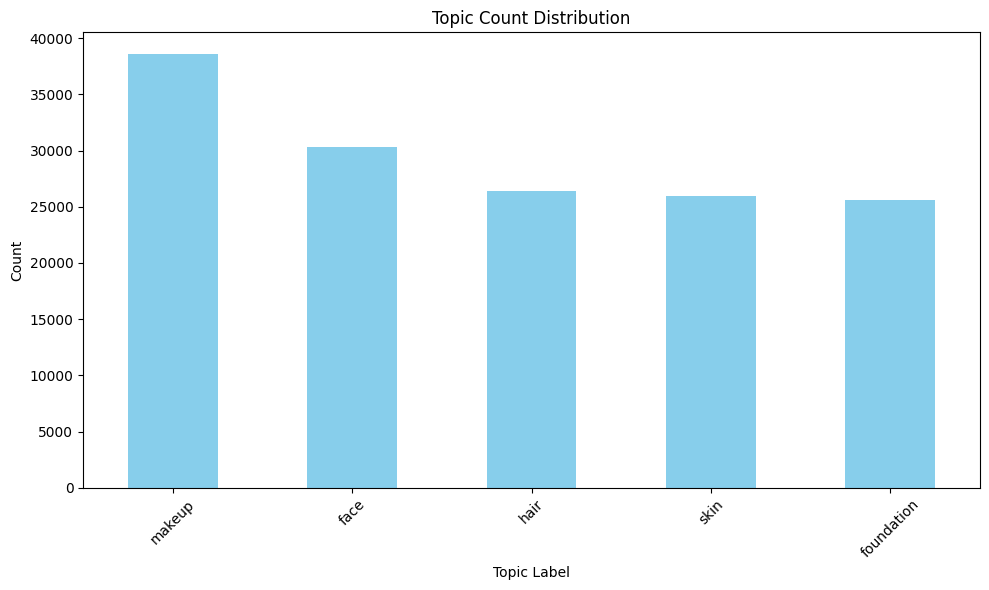

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_neg_makeup.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
negative_data_makeup[['aspect', 'dominant_topic_comment', 'topic_label_comment', 'topic_confidence_comment']].sample(10)

,aspect,dominant_topic_comment,topic_label_comment,topic_confidence_comment
561052,mom,1.0,skin,0.600000
578222,video,2.0,hair,0.600000
361625,perfume,2.0,hair,0.600000
437757,girl,2.0,hair,0.600000
91483,fat,3.0,makeup,0.600000
64076,style,0.0,face,0.600000
33557,makeup,3.0,makeup,0.600000
9068,makeup,3.0,makeup,0.600000
368393,makeup,3.0,makeup,0.600000
120218,hindash,0.0,face,0.599866


In [ ]:
# === 1. Convert Comments to List ===
corpus_pov_makeup = positive_data_makeup['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_pov_makeup)

In [27]:
# === 5. Final Retrain with Best Params ===
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

# lda_topics_v2 contains document-topic distributions ===
print("Shape of document-topic matrix:", lda_topics.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -1126919.2095934795
Perplexity: 465.17825558708995
Shape of document-topic matrix: (176847, 5)


In [29]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('look', np.float64(0.3946)), ('colour', np.float64(0.0281)), ('pakistan', np.float64(0.0234)), ('day', np.float64(0.0218)), ('guy', np.float64(0.0209)), ('boy', np.float64(0.02)), ('didi', np.float64(0.0177)), ('wig', np.float64(0.016)), ('lady', np.float64(0.0155)), ('mashallah', np.float64(0.0114))]

Topic 2: [('looking', np.float64(0.1141)), ('beauty', np.float64(0.0889)), ('lip', np.float64(0.0358)), ('style', np.float64(0.0333)), ('tutorial', np.float64(0.0263)), ('content', np.float64(0.0263)), ('foundation', np.float64(0.0257)), ('dress', np.float64(0.0207)), ('lipstick', np.float64(0.0204)), ('vibe', np.float64(0.017))]

Topic 3: [('hair', np.float64(0.0906)), ('tip', np.float64(0.0444)), ('color', np.float64(0.0421)), ('indian', np.float64(0.0406)), ('personality', np.float64(0.0155)), ('birthday', np.float64(0.0129)), ('work', np.float64(0.0122)), ('looked', np.float64(0.0107)), ('eyeliner', np.float64(0.0103)), ('exercise', np.flo

In [30]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'look', 1: 'looking', 2: 'hair', 3: 'makeup', 4: 'video'}


In [32]:
import numpy as np

# Initialize columns with NaN
positive_data_makeup['dominant_topic_comment'] = np.nan
positive_data_makeup['topic_confidence_comment'] = np.nan
positive_data_makeup['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = positive_data_makeup['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics, axis=1)
topic_confidence = lda_topics.max(axis=1)

# Assign back to the non-null rows
positive_data_makeup.loc[mask, 'dominant_topic_comment'] = dominant_topic
positive_data_makeup.loc[mask, 'topic_confidence_comment'] = topic_confidence
positive_data_makeup.loc[mask, 'topic_label_comment'] = positive_data_makeup.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\3406151726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_makeup['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3406151726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_makeup['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3406151726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [ ]:
topic_counts = positive_data_makeup['topic_label_comment'].value_counts()

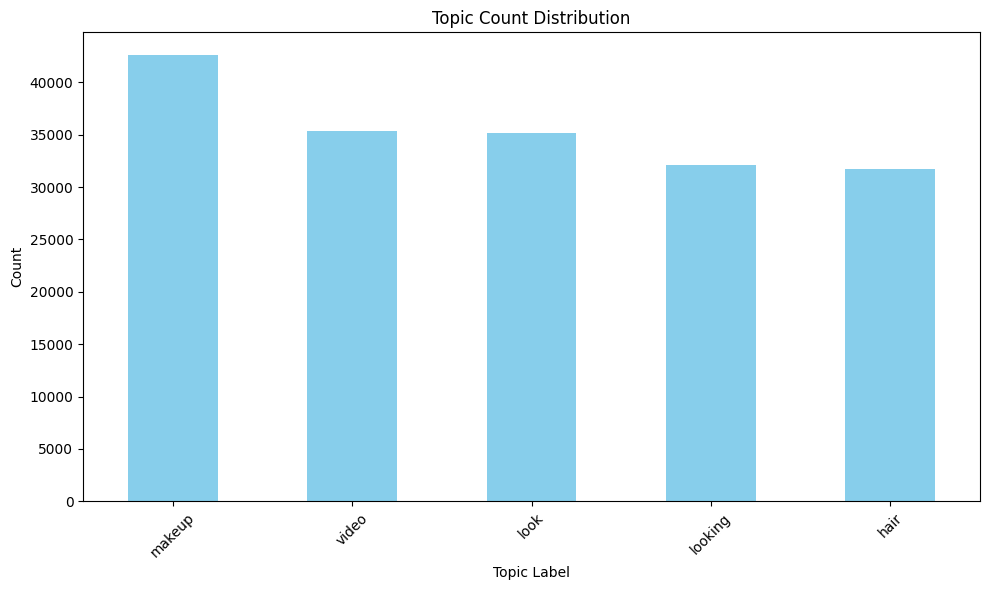

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Repeat the same process for hair category
The same topic modeling and analysis steps are applied to the makeup aspect comments. Both negative and positive comments related to makeup are analyzed using the same workflow, enabling a detailed comparison of topics and sentiments within this product category.

In [ ]:
corpus_neg_hair = negative_data_hair['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_neg_hair)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_neg_hair = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_neg_hair.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -546364.4091724865
Perplexity: 373.1361186185554
Shape of document-topic matrix: (87639, 5)


In [ ]:
# Initialize columns with NaN
negative_data_hair['dominant_topic_comment'] = np.nan
negative_data_hair['topic_confidence_comment'] = np.nan
negative_data_hair['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = negative_data_hair['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_neg_hair, axis=1)
topic_confidence = lda_topics_neg_hair.max(axis=1)

# Assign back to the non-null rows
negative_data_hair.loc[mask, 'dominant_topic_comment'] = dominant_topic
negative_data_hair.loc[mask, 'topic_confidence_comment'] = topic_confidence
negative_data_hair.loc[mask, 'topic_label_comment'] = negative_data_hair.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\1764261696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_hair['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\1764261696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_hair['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\1764261696.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [ ]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('makeup', np.float64(0.1806)), ('color', np.float64(0.1431)), ('style', np.float64(0.0764)), ('cost', np.float64(0.0202)), ('woman', np.float64(0.0186)), ('sound', np.float64(0.0179)), ('beauty', np.float64(0.0172)), ('filter', np.float64(0.0162)), ('song', np.float64(0.0159)), ('blonde', np.float64(0.0157))]

Topic 2: [('cut', np.float64(0.0496)), ('skin', np.float64(0.0344)), ('face', np.float64(0.0245)), ('length', np.float64(0.0242)), ('shampoo', np.float64(0.0227)), ('eye', np.float64(0.021)), ('lady', np.float64(0.0203)), ('braid', np.float64(0.0192)), ('ginger', np.float64(0.0163)), ('fit', np.float64(0.014))]

Topic 3: [('hair', np.float64(0.6948)), ('wig', np.float64(0.0669)), ('hairstyle', np.float64(0.0321)), ('guy', np.float64(0.0304)), ('dress', np.float64(0.0242)), ('eyebrow', np.float64(0.0175)), ('code', np.float64(0.0104)), ('texture', np.float64(0.0095)), ('root', np.float64(0.008)), ('beard', np.float64(0.0075))]

Topic 4:

In [ ]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'makeup', 1: 'cut', 2: 'hair', 3: 'haircut', 4: 'colour'}


In [ ]:
topic_counts_neg_hair = negative_data_hair['topic_label_comment'].value_counts()

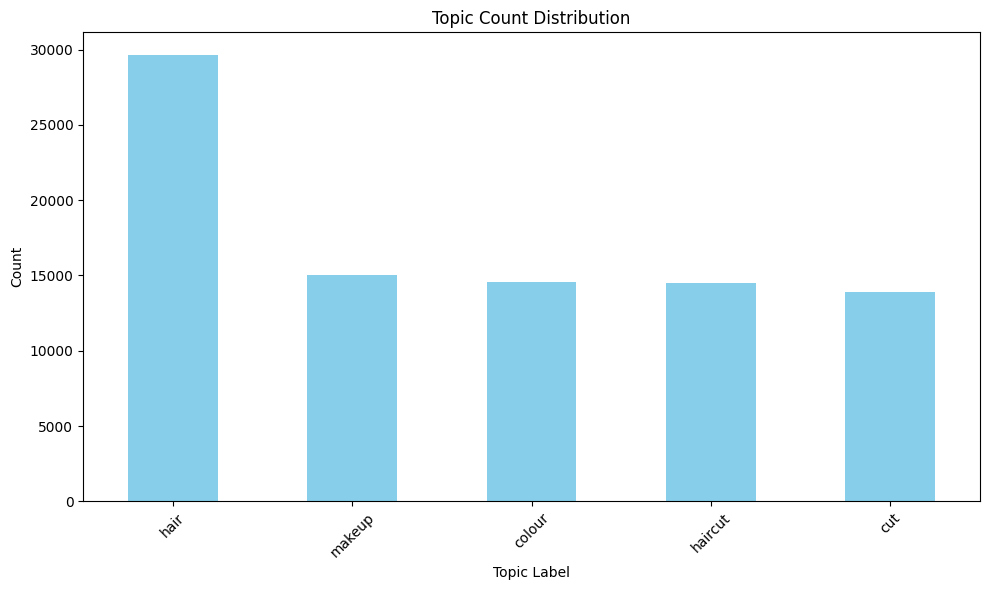

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_neg_hair.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
corpus_pos_hair = positive_data_hair['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_pos_hair)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_pos_hair = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_pos_hair.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -650071.6666115603
Perplexity: 283.4545632311132
Shape of document-topic matrix: (110374, 5)


In [ ]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('makeup', np.float64(0.1681)), ('haircut', np.float64(0.041)), ('transformation', np.float64(0.0348)), ('dress', np.float64(0.0331)), ('smile', np.float64(0.0329)), ('looked', np.float64(0.031)), ('god', np.float64(0.0278)), ('outfit', np.float64(0.0246)), ('love', np.float64(0.0245)), ('brad', np.float64(0.0232))]

Topic 2: [('wig', np.float64(0.1038)), ('face', np.float64(0.0305)), ('girl', np.float64(0.0305)), ('pink', np.float64(0.0297)), ('suit', np.float64(0.0259)), ('lady', np.float64(0.0228)), ('red', np.float64(0.0206)), ('baby', np.float64(0.0187)), ('content', np.float64(0.0141)), ('confidence', np.float64(0.0105))]

Topic 3: [('hair', np.float64(0.415)), ('look', np.float64(0.3571)), ('hairstyle', np.float64(0.0462)), ('colour', np.float64(0.0289)), ('eye', np.float64(0.0212)), ('guy', np.float64(0.0142)), ('vibe', np.float64(0.0114)), ('stylist', np.float64(0.0078)), ('natural', np.float64(0.0064)), ('personality', np.float64(0.

In [ ]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'makeup', 1: 'wig', 2: 'hair', 3: 'color', 4: 'beauty'}


In [ ]:
# Initialize columns with NaN
positive_data_hair['dominant_topic_comment'] = np.nan
positive_data_hair['topic_confidence_comment'] = np.nan
positive_data_hair['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = positive_data_hair['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_pos_hair, axis=1)
topic_confidence = lda_topics_pos_hair.max(axis=1)

# Assign back to the non-null rows
positive_data_hair.loc[mask, 'dominant_topic_comment'] = dominant_topic
positive_data_hair.loc[mask, 'topic_confidence_comment'] = topic_confidence
positive_data_hair.loc[mask, 'topic_label_comment'] = positive_data_hair.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\911777314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_hair['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\911777314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_hair['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\911777314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [ ]:
topic_counts_pos_hair = positive_data_hair['topic_label_comment'].value_counts()

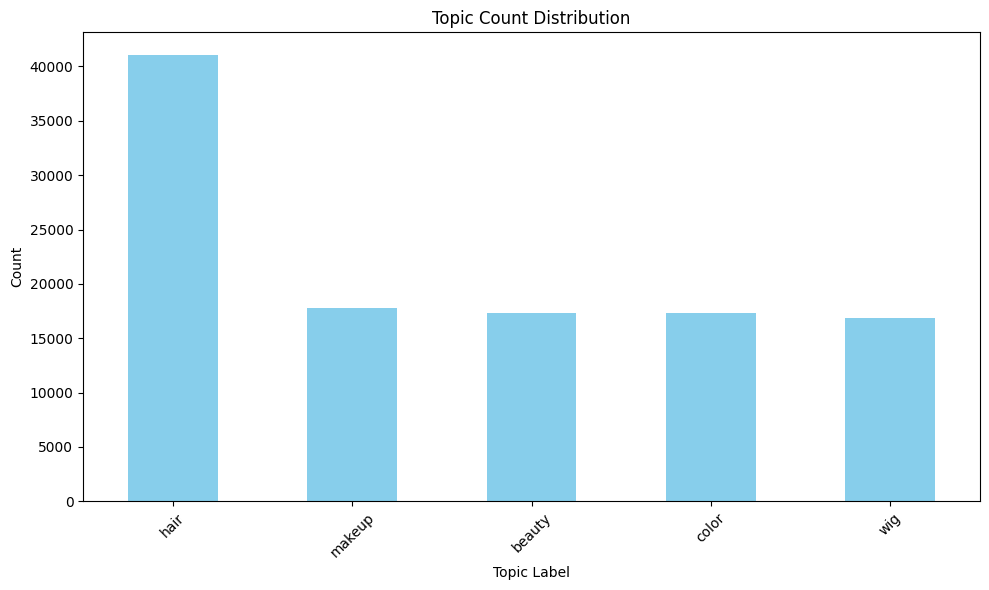

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_pos_hair.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Repeat the same process for skin category
The same topic modeling and analysis steps are applied to the makeup aspect comments. Both negative and positive comments related to makeup are analyzed using the same workflow, enabling a detailed comparison of topics and sentiments within this product category.

In [86]:
corpus_neg_skin = negative_data_skin['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_neg_skin)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_neg_skin = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_neg_skin.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -252671.03049367352
Perplexity: 1004.1427218845587
Shape of document-topic matrix: (34862, 5)


In [89]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('face', np.float64(0.0404)), ('look', np.float64(0.0351)), ('eyeliner', np.float64(0.0296)), ('voice', np.float64(0.0289)), ('food', np.float64(0.026)), ('water', np.float64(0.022)), ('hygiene', np.float64(0.0199)), ('elephant', np.float64(0.0185)), ('mirror', np.float64(0.0151)), ('heel', np.float64(0.0131))]

Topic 2: [('skin', np.float64(0.1194)), ('foundation', np.float64(0.0755)), ('color', np.float64(0.0487)), ('skincare', np.float64(0.0449)), ('cost', np.float64(0.0236)), ('colour', np.float64(0.0227)), ('eyebrow', np.float64(0.0196)), ('song', np.float64(0.0177)), ('shade', np.float64(0.0148)), ('boy', np.float64(0.0122))]

Topic 3: [('lip', np.float64(0.0535)), ('guy', np.float64(0.044)), ('filter', np.float64(0.0412)), ('product', np.float64(0.0352)), ('weight', np.float64(0.0247)), ('body', np.float64(0.0209)), ('sunscreen', np.float64(0.0176)), ('soap', np.float64(0.0141)), ('tutorial', np.float64(0.0129)), ('tip', np.float64(0.0

In [87]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'face', 1: 'skin', 2: 'lip', 3: 'hair', 4: 'makeup'}


In [88]:
# Initialize columns with NaN
negative_data_skin['dominant_topic_comment'] = np.nan
negative_data_skin['topic_confidence_comment'] = np.nan
negative_data_skin['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = negative_data_skin['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_neg_skin, axis=1)
topic_confidence = lda_topics_neg_skin.max(axis=1)

# Assign back to the non-null rows
negative_data_skin.loc[mask, 'dominant_topic_comment'] = dominant_topic
negative_data_skin.loc[mask, 'topic_confidence_comment'] = topic_confidence
negative_data_skin.loc[mask, 'topic_label_comment'] = negative_data_skin.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\3600316834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_skin['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3600316834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_skin['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3600316834.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [90]:
topic_counts_neg_skin = negative_data_skin['topic_label_comment'].value_counts()

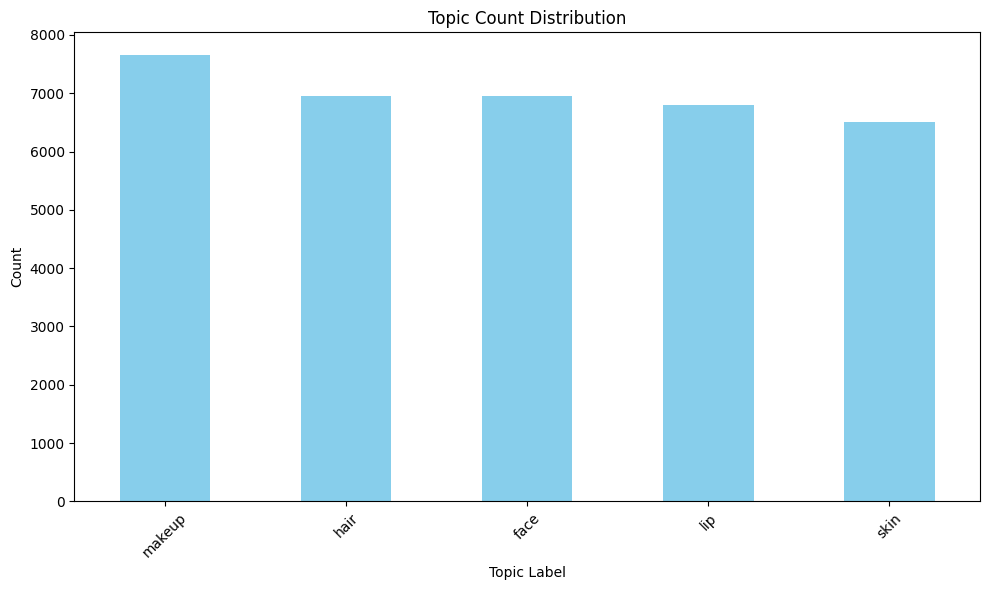

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_neg_skin.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
corpus_pos_skin = positive_data_skin['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_pos_skin)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_pos_skin = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_pos_skin.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -300850.24174827366
Perplexity: 648.7515749974162
Shape of document-topic matrix: (44847, 5)


In [93]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('song', np.float64(0.0345)), ('looking', np.float64(0.0311)), ('brad', np.float64(0.0221)), ('body', np.float64(0.0214)), ('content', np.float64(0.021)), ('vibe', np.float64(0.019)), ('freckle', np.float64(0.0172)), ('talent', np.float64(0.0155)), ('work', np.float64(0.0148)), ('music', np.float64(0.0146))]

Topic 2: [('skin', np.float64(0.2306)), ('hair', np.float64(0.142)), ('beauty', np.float64(0.1376)), ('day', np.float64(0.0195)), ('foundation', np.float64(0.0191)), ('guy', np.float64(0.0176)), ('baby', np.float64(0.0146)), ('olivia', np.float64(0.0137)), ('make', np.float64(0.0136)), ('smell', np.float64(0.0127))]

Topic 3: [('makeup', np.float64(0.3503)), ('look', np.float64(0.241)), ('selena', np.float64(0.0634)), ('voice', np.float64(0.0426)), ('god', np.float64(0.0302)), ('sharing', np.float64(0.0204)), ('colour', np.float64(0.0157)), ('eyeliner', np.float64(0.0082)), ('vogue', np.float64(0.008)), ('cover', np.float64(0.0062))]

To

In [94]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'song', 1: 'skin', 2: 'makeup', 3: 'eye', 4: 'video'}


In [95]:
# Initialize columns with NaN
positive_data_skin['dominant_topic_comment'] = np.nan
positive_data_skin['topic_confidence_comment'] = np.nan
positive_data_skin['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = positive_data_skin['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_pos_skin, axis=1)
topic_confidence = lda_topics_pos_skin.max(axis=1)

# Assign back to the non-null rows
positive_data_skin.loc[mask, 'dominant_topic_comment'] = dominant_topic
positive_data_skin.loc[mask, 'topic_confidence_comment'] = topic_confidence
positive_data_skin.loc[mask, 'topic_label_comment'] = positive_data_skin.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\2351053705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_skin['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\2351053705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_skin['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\2351053705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [96]:
topic_counts_pos_skin = positive_data_skin['topic_label_comment'].value_counts()

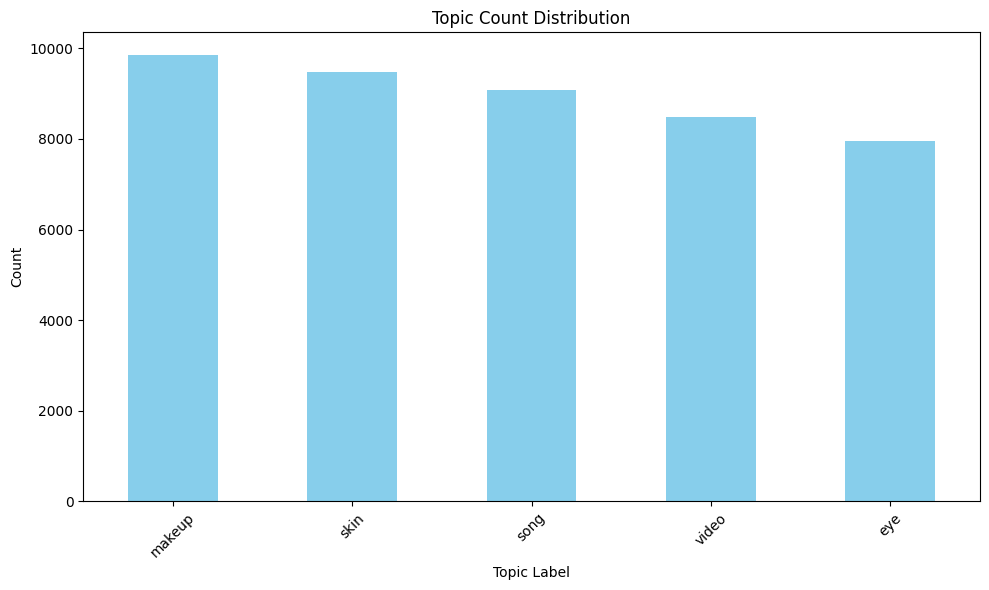

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_pos_skin.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Repeat the same process for perfume category
The same topic modeling and analysis steps are applied to the makeup aspect comments. Both negative and positive comments related to makeup are analyzed using the same workflow, enabling a detailed comparison of topics and sentiments within this product category.

In [100]:
corpus_neg_perfume = negative_data_perfume['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_neg_perfume)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_neg_perfume = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_neg_perfume.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -159947.94270539924
Perplexity: 730.6160346831022
Shape of document-topic matrix: (23130, 5)


In [101]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('makeup', np.float64(0.2534)), ('lip', np.float64(0.0731)), ('eye', np.float64(0.04)), ('sun', np.float64(0.0286)), ('nose', np.float64(0.0229)), ('sunscreen', np.float64(0.0218)), ('woman', np.float64(0.0187)), ('lady', np.float64(0.0127)), ('weight', np.float64(0.0125)), ('picture', np.float64(0.0097))]

Topic 2: [('hair', np.float64(0.2946)), ('eyebrow', np.float64(0.0969)), ('face', np.float64(0.0465)), ('video', np.float64(0.0373)), ('lash', np.float64(0.0133)), ('waiting', np.float64(0.0117)), ('acne', np.float64(0.0115)), ('food', np.float64(0.0109)), ('towel', np.float64(0.0104)), ('mime', np.float64(0.0094))]

Topic 3: [('filter', np.float64(0.1498)), ('color', np.float64(0.0437)), ('trust', np.float64(0.0345)), ('guy', np.float64(0.031)), ('girl', np.float64(0.0183)), ('fit', np.float64(0.017)), ('curl', np.float64(0.0138)), ('advertising', np.float64(0.0106)), ('leg', np.float64(0.0102)), ('skinny', np.float64(0.0094))]

Topic 4: 

In [102]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'makeup', 1: 'hair', 2: 'filter', 3: 'skin', 4: 'tape'}


In [103]:
# Initialize columns with NaN
negative_data_perfume['dominant_topic_comment'] = np.nan
negative_data_perfume['topic_confidence_comment'] = np.nan
negative_data_perfume['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = negative_data_perfume['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_neg_perfume, axis=1)
topic_confidence = lda_topics_neg_perfume.max(axis=1)

# Assign back to the non-null rows
negative_data_perfume.loc[mask, 'dominant_topic_comment'] = dominant_topic
negative_data_perfume.loc[mask, 'topic_confidence_comment'] = topic_confidence
negative_data_perfume.loc[mask, 'topic_label_comment'] = negative_data_perfume.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\3285952989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_perfume['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3285952989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_perfume['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\3285952989.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [104]:
topic_counts_neg_perfume = negative_data_perfume['topic_label_comment'].value_counts()

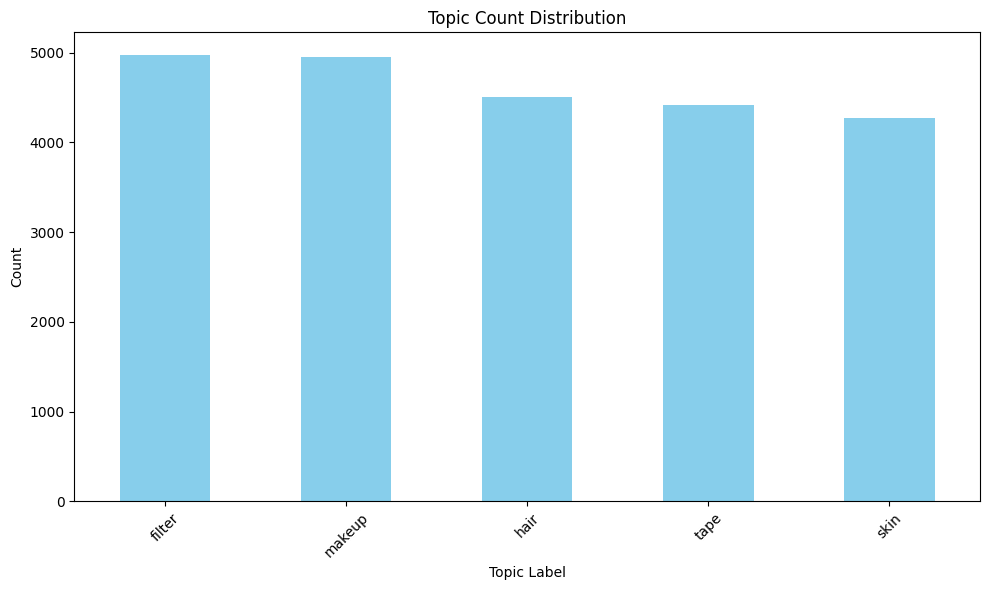

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_neg_perfume.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [106]:
corpus_pos_perfume = positive_data_perfume['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_pos_perfume)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_pos_perfume = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_pos_perfume.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -155104.48463584017
Perplexity: 682.1299759594115
Shape of document-topic matrix: (23275, 5)


In [107]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('makeup', np.float64(0.2804)), ('thai', np.float64(0.0245)), ('feature', np.float64(0.0193)), ('perfume', np.float64(0.0117)), ('smell', np.float64(0.0115)), ('edit', np.float64(0.0109)), ('acting', np.float64(0.0086)), ('beetlejuice', np.float64(0.008)), ('morena', np.float64(0.0074)), ('mashallah', np.float64(0.007))]

Topic 2: [('look', np.float64(0.2844)), ('hair', np.float64(0.1638)), ('video', np.float64(0.0824)), ('filter', np.float64(0.0429)), ('transition', np.float64(0.0292)), ('tape', np.float64(0.0227)), ('god', np.float64(0.0173)), ('jean', np.float64(0.0138)), ('foundation', np.float64(0.0136)), ('body', np.float64(0.0103))]

Topic 3: [('fiona', np.float64(0.0816)), ('eyebrow', np.float64(0.0527)), ('eye', np.float64(0.0466)), ('style', np.float64(0.0452)), ('looking', np.float64(0.0285)), ('vibe', np.float64(0.0224)), ('girl', np.float64(0.0219)), ('wig', np.float64(0.0207)), ('sharing', np.float64(0.0198)), ('baby', np.float6

In [108]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'makeup', 1: 'look', 2: 'fiona', 3: 'editing', 4: 'skin'}


In [109]:
# Initialize columns with NaN
positive_data_perfume['dominant_topic_comment'] = np.nan
positive_data_perfume['topic_confidence_comment'] = np.nan
positive_data_perfume['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = positive_data_perfume['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_pos_perfume, axis=1)
topic_confidence = lda_topics_pos_perfume.max(axis=1)

# Assign back to the non-null rows
positive_data_perfume.loc[mask, 'dominant_topic_comment'] = dominant_topic
positive_data_perfume.loc[mask, 'topic_confidence_comment'] = topic_confidence
positive_data_perfume.loc[mask, 'topic_label_comment'] = positive_data_perfume.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\2508226352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_perfume['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\2508226352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_perfume['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\2508226352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [112]:
topic_counts_pos_perfume = positive_data_perfume['topic_label_comment'].value_counts()

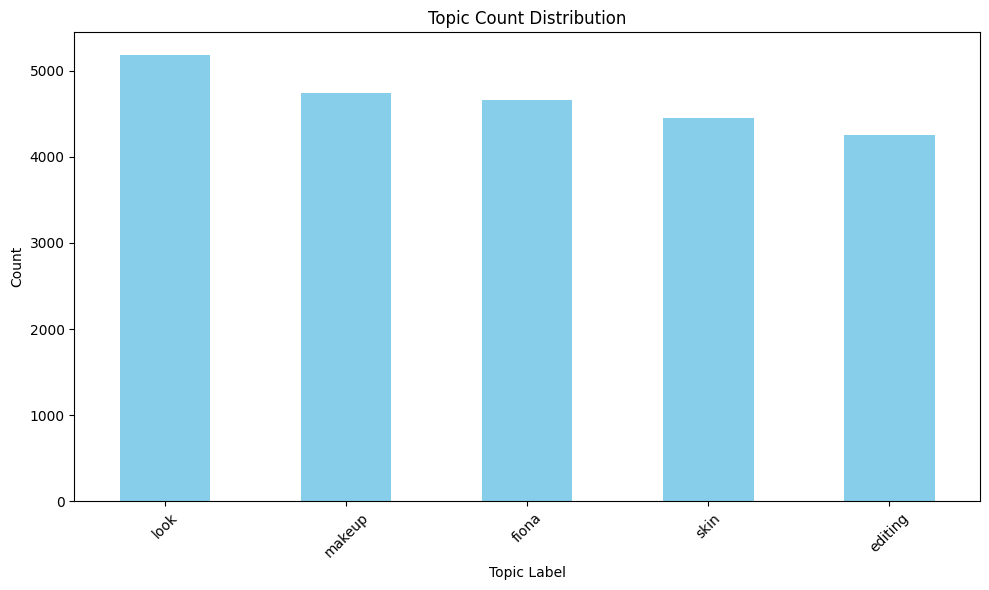

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_pos_perfume.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Repeat the same process for body category
The same topic modeling and analysis steps are applied to the makeup aspect comments. Both negative and positive comments related to makeup are analyzed using the same workflow, enabling a detailed comparison of topics and sentiments within this product category.

In [116]:
corpus_neg_body = negative_data_body['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_neg_body)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_neg_body = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_neg_body.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -114209.51910880089
Perplexity: 913.4765923720139
Shape of document-topic matrix: (16076, 5)


In [117]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('eyelash', np.float64(0.0324)), ('animal', np.float64(0.0317)), ('tan', np.float64(0.0222)), ('lash', np.float64(0.0221)), ('sound', np.float64(0.0215)), ('clothes', np.float64(0.0175)), ('style', np.float64(0.0153)), ('boy', np.float64(0.0118)), ('cream', np.float64(0.0108)), ('shade', np.float64(0.0099))]

Topic 2: [('foundation', np.float64(0.0683)), ('voice', np.float64(0.0668)), ('woman', np.float64(0.0427)), ('look', np.float64(0.0298)), ('baby', np.float64(0.0295)), ('wig', np.float64(0.0289)), ('girl', np.float64(0.0248)), ('product', np.float64(0.0247)), ('eyebrow', np.float64(0.0242)), ('man', np.float64(0.024))]

Topic 3: [('color', np.float64(0.0736)), ('skin', np.float64(0.0651)), ('guy', np.float64(0.0511)), ('colour', np.float64(0.0393)), ('video', np.float64(0.0363)), ('green', np.float64(0.0362)), ('soap', np.float64(0.0296)), ('shirt', np.float64(0.0188)), ('accent', np.float64(0.0174)), ('lady', np.float64(0.0099))]

Topic

In [118]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'eyelash', 1: 'foundation', 2: 'color', 3: 'makeup', 4: 'hair'}


In [119]:
# Initialize columns with NaN
negative_data_body['dominant_topic_comment'] = np.nan
negative_data_body['topic_confidence_comment'] = np.nan
negative_data_body['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = negative_data_body['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_neg_body, axis=1)
topic_confidence = lda_topics_neg_body.max(axis=1)

# Assign back to the non-null rows
negative_data_body.loc[mask, 'dominant_topic_comment'] = dominant_topic
negative_data_body.loc[mask, 'topic_confidence_comment'] = topic_confidence
negative_data_body.loc[mask, 'topic_label_comment'] = negative_data_body.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\1327275353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_body['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\1327275353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data_body['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\1327275353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [120]:
topic_counts_neg_body = negative_data_body['topic_label_comment'].value_counts()

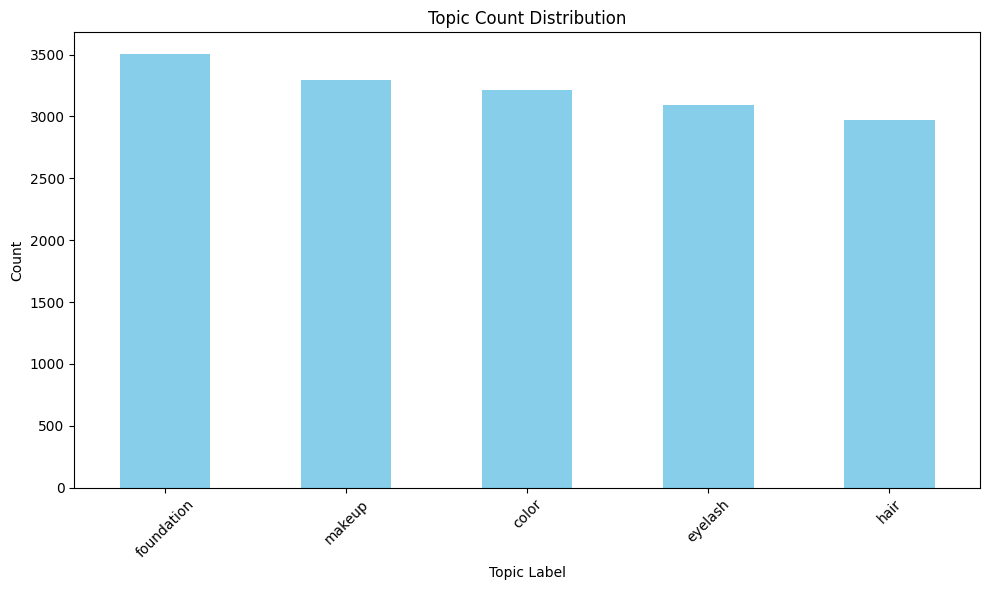

In [121]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_neg_body.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [122]:
corpus_pos_body = positive_data_body['aspect'].dropna().astype(str).tolist()
count_vectorizer = CountVectorizer(stop_words='english', lowercase=True)
count_data_vectorized = count_vectorizer.fit_transform(corpus_pos_body)
final_lda = LatentDirichletAllocation(
    n_components=5,
    learning_decay=0.7,
    random_state=42,
    learning_method="online",
    batch_size=1024,
    max_iter=15,
    verbose=1
)

# Fit final model on full dataset ===
lda_topics_pos_body = final_lda.fit_transform(count_data_vectorized)

# Evaluate the model ===
log_likelihood = final_lda.score(count_data_vectorized)
perplexity = final_lda.perplexity(count_data_vectorized)

print("Final LDA trained on full dataset!")
print(f"Log Likelihood: {log_likelihood}")
print(f"Perplexity: {perplexity}")

print("Shape of document-topic matrix:", lda_topics_pos_body.shape)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15
Final LDA trained on full dataset!
Log Likelihood: -138523.6693301262
Perplexity: 528.6407720649692
Shape of document-topic matrix: (21428, 5)


In [123]:
print("LDA Topics (with probabilities):")
lda_keywords = print_topics(final_lda, count_vectorizer, top_n=10, show_probs=True)


LDA Topics (with probabilities):

Topic 1: [('makeup', np.float64(0.3659)), ('eye', np.float64(0.0397)), ('guy', np.float64(0.0301)), ('wig', np.float64(0.0187)), ('god', np.float64(0.0162)), ('hairstyle', np.float64(0.0084)), ('babe', np.float64(0.0083)), ('white', np.float64(0.0077)), ('work', np.float64(0.0075)), ('brown', np.float64(0.007))]

Topic 2: [('look', np.float64(0.3348)), ('color', np.float64(0.1413)), ('hair', np.float64(0.1025)), ('looking', np.float64(0.0694)), ('eyelash', np.float64(0.0195)), ('sound', np.float64(0.0126)), ('red', np.float64(0.0123)), ('smell', np.float64(0.0093)), ('trend', np.float64(0.0091)), ('foundation', np.float64(0.0089))]

Topic 3: [('voice', np.float64(0.1579)), ('video', np.float64(0.0887)), ('skin', np.float64(0.0876)), ('purple', np.float64(0.0438)), ('green', np.float64(0.0341)), ('man', np.float64(0.0225)), ('baby', np.float64(0.0217)), ('lip', np.float64(0.021)), ('song', np.float64(0.0153)), ('love', np.float64(0.0143))]

Topic 4: [('

In [124]:
# Assume lda_model and count_vectorizer are already fitted
feature_names = count_vectorizer.get_feature_names_out()

topic_labels = {}
for idx, topic in enumerate(final_lda.components_):
    top_keyword_index = topic.argmax()  # index of the top word
    top_keyword = feature_names[top_keyword_index]
    topic_labels[idx] = top_keyword

print("Topic Labels:", topic_labels)

Topic Labels: {0: 'makeup', 1: 'look', 2: 'voice', 3: 'accent', 4: 'colour'}


In [125]:
# Initialize columns with NaN
positive_data_body['dominant_topic_comment'] = np.nan
positive_data_body['topic_confidence_comment'] = np.nan
positive_data_body['topic_label_comment'] = np.nan

# Mask for non-null rows
mask = positive_data_body['aspect'].notnull()

# Compute only on rows that were vectorized
dominant_topic = np.argmax(lda_topics_pos_body, axis=1)
topic_confidence = lda_topics_pos_body.max(axis=1)

# Assign back to the non-null rows
positive_data_body.loc[mask, 'dominant_topic_comment'] = dominant_topic
positive_data_body.loc[mask, 'topic_confidence_comment'] = topic_confidence
positive_data_body.loc[mask, 'topic_label_comment'] = positive_data_body.loc[mask, 'dominant_topic_comment'].map(topic_labels)


C:\Users\user\AppData\Local\Temp\ipykernel_1964\1132669183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_body['dominant_topic_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\1132669183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data_body['topic_confidence_comment'] = np.nan
C:\Users\user\AppData\Local\Temp\ipykernel_1964\1132669183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [126]:
topic_counts_pos_body = positive_data_body['topic_label_comment'].value_counts()

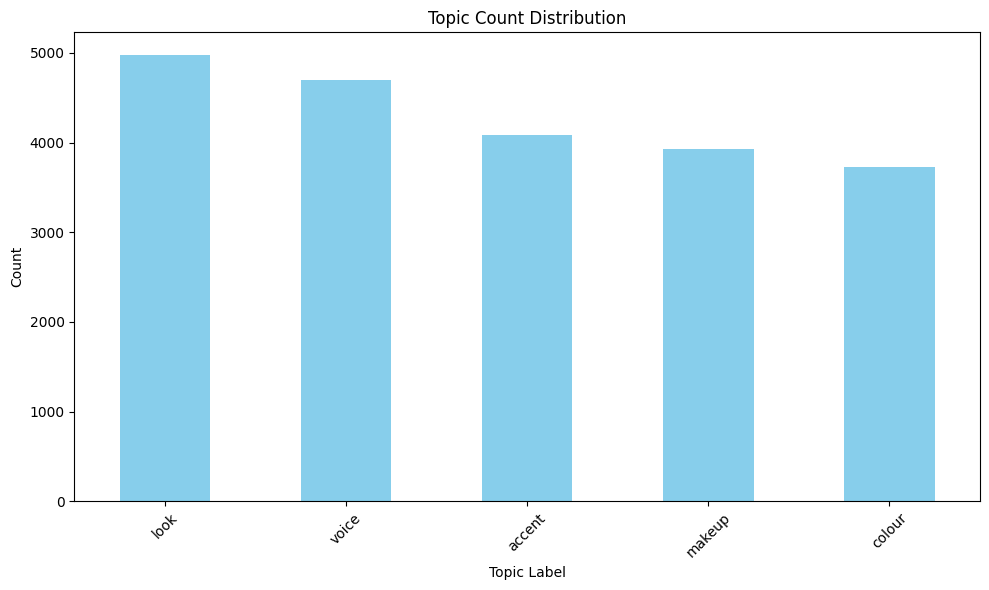

In [127]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
topic_counts_pos_body.plot(kind='bar', color='skyblue')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Count Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### All topic counts are listed below
The following output displays the value counts for each topic, showing how many comments are assigned to each topic label.

In [ ]:
topic_counts_neg_overall = negative_data['topic_label_comment'].value_counts()
topic_counts_neg_overall

topic_label_comment
makeup        91309
lip           60058
color         57965
foundation    57817
skin          56117
Name: count, dtype: int64

In [ ]:
topic_counts_pos_overall = positive_data['topic_label_comment'].value_counts()
topic_counts_pos_overall

topic_label_comment
makeup        136391
skin           66937
foundation     65232
lip            61057
color          59046
Name: count, dtype: int64

In [ ]:
topic_counts_neg_makeup = negative_data_makeup['topic_label_comment'].value_counts()
topic_counts_neg_makeup

topic_label_comment
makeup        38586
face          30304
hair          26419
skin          25948
foundation    25560
Name: count, dtype: int64

In [ ]:
topic_counts_pov_makeup = positive_data_makeup['topic_label_comment'].value_counts()
topic_counts_pov_makeup

topic_label_comment
makeup     42644
video      35313
look       35119
looking    32068
hair       31703
Name: count, dtype: int64

In [ ]:
topic_counts_neg_hair = negative_data_hair['topic_label_comment'].value_counts()
topic_counts_neg_hair

topic_label_comment
hair       29663
makeup     15042
colour     14532
haircut    14484
cut        13918
Name: count, dtype: int64

In [ ]:
topic_counts_pos_hair = positive_data_hair['topic_label_comment'].value_counts()
topic_counts_pos_hair

topic_label_comment
hair      41087
makeup    17754
beauty    17364
color     17314
wig       16855
Name: count, dtype: int64

In [ ]:
topic_counts_neg_skin = negative_data_skin['topic_label_comment'].value_counts()
topic_counts_neg_skin

topic_label_comment
makeup    7662
hair      6961
face      6946
lip       6794
skin      6499
Name: count, dtype: int64

In [ ]:
topic_counts_pos_skin = positive_data_skin['topic_label_comment'].value_counts()
topic_counts_pos_skin

topic_label_comment
makeup    9861
skin      9475
song      9080
video     8474
eye       7957
Name: count, dtype: int64

In [ ]:
topic_counts_neg_perfume = negative_data_perfume['topic_label_comment'].value_counts()
topic_counts_neg_perfume 


topic_label_comment
filter    4979
makeup    4948
hair      4510
tape      4419
skin      4274
Name: count, dtype: int64

In [ ]:
topic_counts_pos_perfume = positive_data_perfume['topic_label_comment'].value_counts()
topic_counts_pos_perfume

topic_label_comment
look       5185
makeup     4735
fiona      4656
skin       4448
editing    4251
Name: count, dtype: int64

In [ ]:
topic_counts_neg_body = negative_data_body['topic_label_comment'].value_counts()
topic_counts_neg_body

topic_label_comment
foundation    3504
makeup        3294
color         3215
eyelash       3094
hair          2969
Name: count, dtype: int64

In [ ]:
topic_counts_pos_body = positive_data_body['topic_label_comment'].value_counts()
topic_counts_pos_body

topic_label_comment
look      4981
voice     4694
accent    4086
makeup    3934
colour    3733
Name: count, dtype: int64

### Combine and save all topic counts to CSV
This cell combines the topic count Series for each sentiment and category into a single DataFrame, then saves the results to a CSV file (`comment_sentiment_analysis.csv`). This file provides a comprehensive summary of topic distributions across all aspects and sentiment categories for further analysis or reporting.

In [ ]:
# Combine all topic count Series into a DataFrame and save to CSV
topic_counts_dict = {
    'neg_overall': topic_counts_neg_overall,
    'pos_overall': topic_counts_pos_overall,
    'neg_makeup': topic_counts_neg_makeup,
    'pos_makeup': topic_counts_pov_makeup,
    'neg_hair': topic_counts_neg_hair,
    'pos_hair': topic_counts_pos_hair,
    'neg_skin': topic_counts_neg_skin,
    'pos_skin': topic_counts_pos_skin,
    'neg_perfume': topic_counts_neg_perfume,
    'pos_perfume': topic_counts_pos_perfume,
    'neg_body': topic_counts_neg_body,
    'pos_body': topic_counts_pos_body
}

# Convert all Series to DataFrames and join on index (topic label)
topic_counts_df = pd.concat(topic_counts_dict, axis=1).fillna(0)
topic_counts_df.columns = [
    'neg_overall', 'pos_overall', 'neg_makeup', 'pos_makeup', 'neg_hair', 'pos_hair',
    'neg_skin', 'pos_skin', 'neg_perfume', 'pos_perfume', 'neg_body', 'pos_body'
 ]
topic_counts_df.to_csv('dataset/comment_sentiment_analysis.csv')
print('Saved all topic counts to comment_sentiment_analysis.csv')

Saved all topic counts to comment_sentiment_analysis.csv


### Display the combined topic counts DataFrame
This cell displays the DataFrame containing topic counts for each sentiment and aspect category, providing a comprehensive overview of the topic distribution across all analyzed comments.

In [ ]:
topic_counts_df

,neg_overall,pos_overall,neg_makeup,pos_makeup,neg_hair,pos_hair,neg_skin,pos_skin,neg_perfume,pos_perfume,neg_body,pos_body
topic_label_comment,,,,,,,,,,,,
makeup,91309.0,136391.0,38586.0,42644.0,15042.0,17754.0,7662.0,9861.0,4948.0,4735.0,3294.0,3934.0
lip,60058.0,61057.0,0.0,0.0,0.0,0.0,6794.0,0.0,0.0,0.0,0.0,0.0
color,57965.0,59046.0,0.0,0.0,0.0,17314.0,0.0,0.0,0.0,0.0,3215.0,0.0
foundation,57817.0,65232.0,25560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3504.0,0.0
skin,56117.0,66937.0,25948.0,0.0,0.0,0.0,6499.0,9475.0,4274.0,4448.0,0.0,0.0
face,0.0,0.0,30304.0,0.0,0.0,0.0,6946.0,0.0,0.0,0.0,0.0,0.0
hair,0.0,0.0,26419.0,31703.0,29663.0,41087.0,6961.0,0.0,4510.0,0.0,2969.0,0.0
video,0.0,0.0,0.0,35313.0,0.0,0.0,0.0,8474.0,0.0,0.0,0.0,0.0
look,0.0,0.0,0.0,35119.0,0.0,0.0,0.0,0.0,0.0,5185.0,0.0,4981.0
